In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [187]:
online_marketing = pd.read_csv("./OnlineMarketingData.csv")
offline_marketing = pd.read_csv("./OfflineMarketingData.csv")
pricing_data = pd.read_csv("./PricingData.csv")
sales_data = pd.read_csv("./SalesData.csv")

In [188]:
# Read sales data and convert to date to datetime
sales_data['date'] =  pd.to_datetime(sales_data['date'])

#read offline marketing data and convert week to datetime
offline_marketing['week'] = pd.to_datetime(offline_marketing['week'])

#read online marketing data and convert to datetime
online_marketing['date'] = pd.to_datetime(online_marketing['date'])

In [189]:
sales_data

,date,city,state,store_id,product_id,sales_quantity
0,2023-01-01,Mumbai,Maharashtra,MUM_01,P001,112
1,2023-01-01,Mumbai,Maharashtra,MUM_01,P002,100
2,2023-01-01,Mumbai,Maharashtra,MUM_01,P003,126
3,2023-01-01,Mumbai,Maharashtra,MUM_01,P004,108
4,2023-01-01,Mumbai,Maharashtra,MUM_01,P005,129
...,...,...,...,...,...,...
554795,2023-12-31,Guwahati,Assam,GUW_05,P004,71
554796,2023-12-31,Guwahati,Assam,GUW_05,P005,100
554797,2023-12-31,Guwahati,Assam,GUW_05,P006,96
554798,2023-12-31,Guwahati,Assam,GUW_05,P007,136


## Task 1: Time Series Visualization with Misaligned Time Frequencies and Scale Differences

In [190]:
# Calculate total daily sales to match with marketing data
daily_sales = sales_data.groupby('date')['sales_quantity'].sum().reset_index()
daily_sales.rename(columns={'sales_quantity': 'total_sales'}, inplace=True)

In [193]:
weekly_sales = daily_sales.copy()
weekly_sales["week"] = (
    pd.to_datetime(weekly_sales["date"]).dt.to_period("W").dt.start_time
)
weekly_sales

,date,total_sales,week
0,2023-01-01,143153,2022-12-26
1,2023-01-02,145152,2023-01-02
2,2023-01-03,144708,2023-01-02
3,2023-01-04,143017,2023-01-02
4,2023-01-05,145002,2023-01-02
...,...,...,...
360,2023-12-27,143893,2023-12-25
361,2023-12-28,142356,2023-12-25
362,2023-12-29,143916,2023-12-25
363,2023-12-30,141498,2023-12-25


In [194]:
weekly_sales = weekly_sales.groupby("week")["total_sales"].sum().reset_index()
weekly_sales

,week,total_sales
0,2022-12-26,143153
1,2023-01-02,1009291
2,2023-01-09,1007854
3,2023-01-16,1006634
4,2023-01-23,1007046
5,2023-01-30,1004016
6,2023-02-06,1008827
7,2023-02-13,1001100
8,2023-02-20,1003771
9,2023-02-27,1004105


In [183]:
# Aggregate weekly sales for comparison with weekly media spend
weekly_sales = daily_sales.copy()
weekly_sales["week"] = (
    pd.to_datetime(weekly_sales["date"]).dt.to_period("W").dt.start_time
)
weekly_sales = weekly_sales.groupby("week")["total_sales"].sum().reset_index()

# Ensure the 'date' column is in datetime format
weekly_sales["week"] = pd.to_datetime(weekly_sales["week"])
# Set 'date' as the index
weekly_sales.set_index("week", inplace=True)

# Resample the data to start the weekly window from 2023-01-01
start_date = pd.to_datetime("2023-01-01")
weekly_sales = weekly_sales.resample(
    "W-SUN", label="left", offset="1D", origin=start_date
).sum()

# Reset the index
weekly_sales.reset_index(inplace=True)
# Convert 'date' column to datetime
weekly_sales["week"] = pd.to_datetime(weekly_sales["week"])

# Set 'date' as the index for easier manipulation
weekly_sales.set_index("week", inplace=True)
# Shift the data by 1 week
df_shifted = weekly_sales.shift(periods=1, freq="W")

# If you want to reset the index for easier viewing
df_shifted.reset_index(inplace=True)

In [ ]:
# Merge digital data with daily sales for analysis
digital_sales = pd.merge(online_marketing, daily_sales, on='date', how='left')

# Convert the 'date' column to datetime
digital_sales["date"] = pd.to_datetime(digital_sales["date"])

# Set the 'date' column as the index
digital_sales.set_index("date", inplace=True)

# Resample data weekly and sum spend for each channel
weekly_spend = (
    digital_sales.groupby("channel").resample("W").sum()["spend"].reset_index()
)

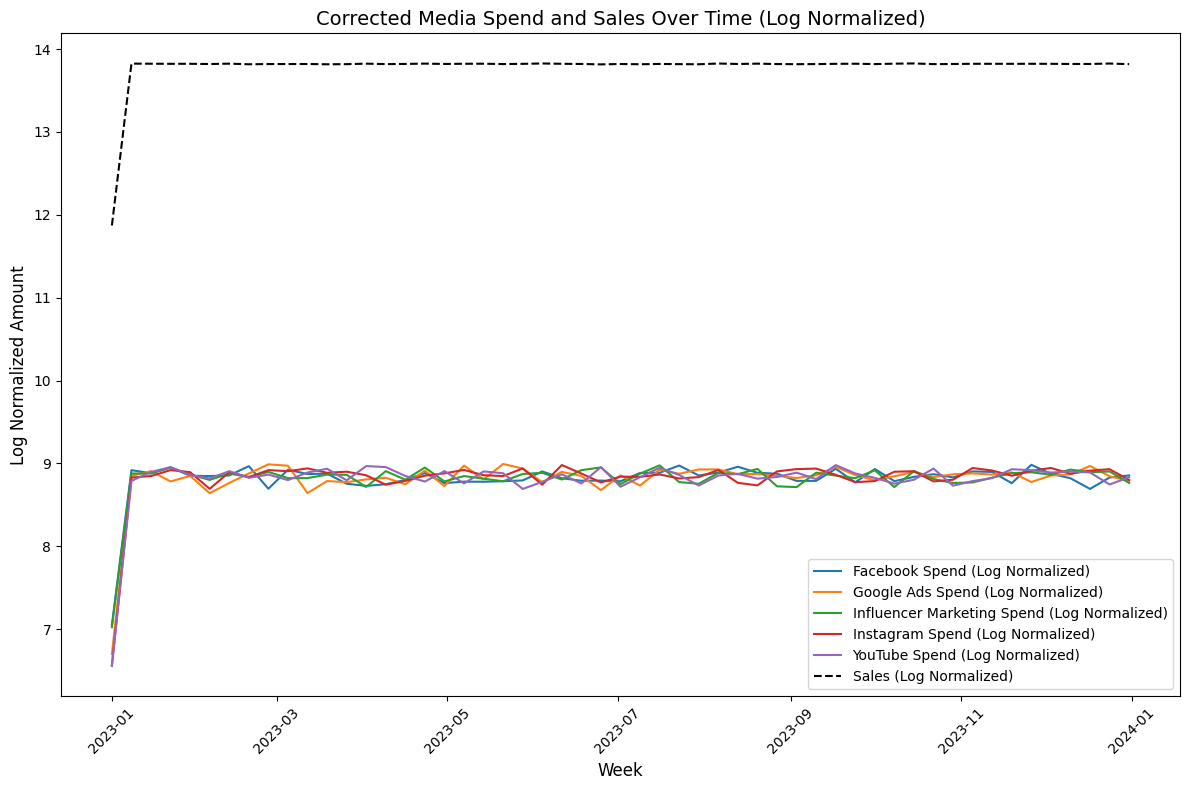

In [ ]:
def plot_corrected_time_series_online(online_marketing, weekly_sales):
    # Step 1: Pivot media spend data
    online_data_pivoted = online_marketing.pivot_table(
        index="date", columns="channel", values="spend", aggfunc="sum"
    )
    online_data_pivoted.index = pd.to_datetime(
        online_data_pivoted.index
    )  # Ensure datetime index

    # Step 2: Resample sales data to weekly frequency
    weekly_sales["week"] = pd.to_datetime(
        weekly_sales["week"]
    )  # Ensure datetime format
    weekly_sales_resampled = weekly_sales.set_index("week").resample("W").sum()

    # Step 3: Normalize data using log transformation
    offline_data_normalized = np.log1p(
        online_data_pivoted
    )  # Log transformation for media spend
    sales_normalized = np.log1p(
        weekly_sales_resampled["total_sales"]
    )  # Log transformation for sales

    # Step 4: Plot corrected time series
    plt.figure(figsize=(12, 8))

    # Plot normalized media spend
    for channel in offline_data_normalized.columns:
        plt.plot(
            offline_data_normalized.index,
            offline_data_normalized[channel],
            label=f"{channel} Spend (Log Normalized)",
        )

    # Plot normalized sales
    plt.plot(
        sales_normalized.index,
        sales_normalized,
        label="Sales (Log Normalized)",
        linestyle="--",
        color="black",
    )

    # Add titles and labels
    plt.title("Corrected Media Spend and Sales Over Time (Log Normalized)", fontsize=14)
    plt.xlabel("Week", fontsize=12)
    plt.ylabel("Log Normalized Amount", fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_corrected_time_series_online(weekly_spend, df_shifted)

In [161]:
# Merge weekly media spend with weekly sales
media_sales = pd.merge(offline_marketing, df_shifted, on='week', how='left')

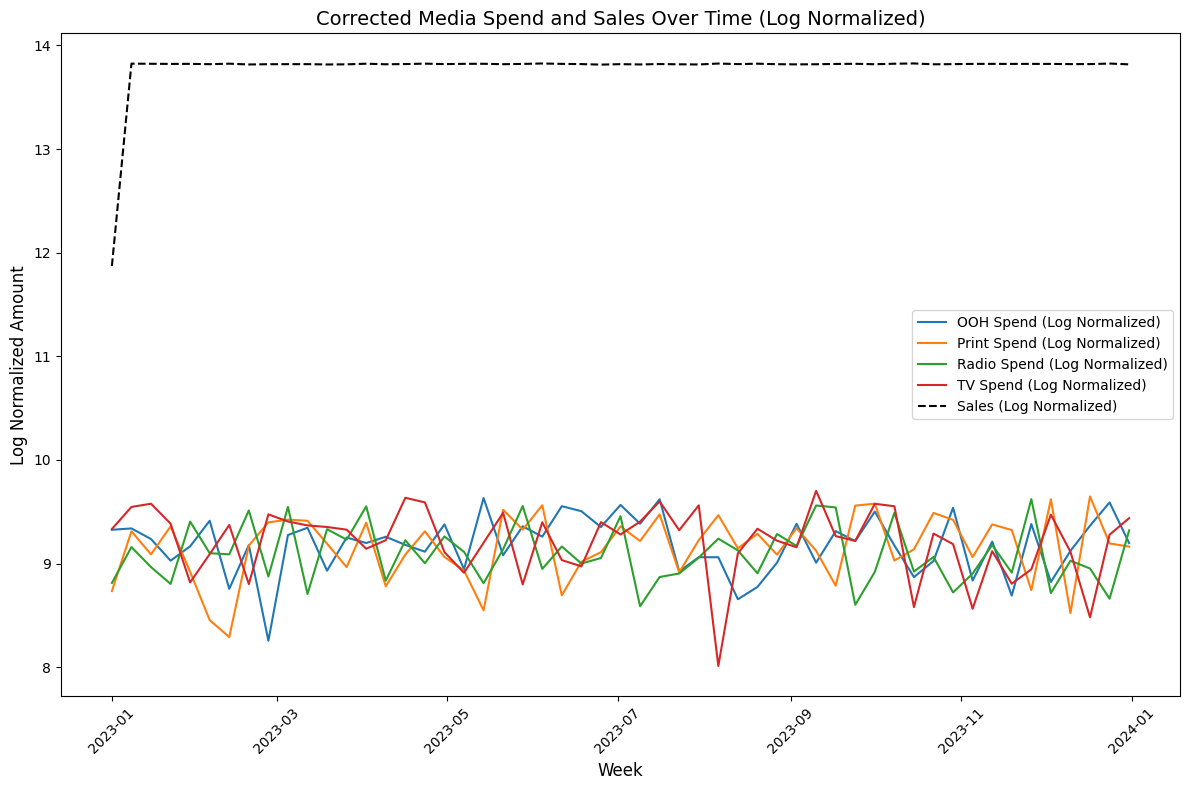

In [ ]:
def plot_corrected_time_series_offline(offline_marketing, weekly_sales):
    # Step 1: Pivot media spend data
    offline_data_pivoted = offline_marketing.pivot_table(
        index="week", columns="channel", values="spend", aggfunc="sum"
    )
    offline_data_pivoted.index = pd.to_datetime(
        offline_data_pivoted.index
    )  # Ensure datetime index

    # Step 2: Resample sales data to weekly frequency
    weekly_sales["week"] = pd.to_datetime(
        weekly_sales["week"]
    )  # Ensure datetime format
    weekly_sales_resampled = weekly_sales.set_index("week").resample("W").sum()

    # Step 3: Normalize data using log transformation
    offline_data_normalized = np.log1p(
        offline_data_pivoted
    )  # Log transformation for media spend
    sales_normalized = np.log1p(
        weekly_sales_resampled["total_sales"]
    )  # Log transformation for sales

    # Step 4: Plot corrected time series
    plt.figure(figsize=(12, 8))

    # Plot normalized media spend
    for channel in offline_data_normalized.columns:
        plt.plot(
            offline_data_normalized.index,
            offline_data_normalized[channel],
            label=f"{channel} Spend (Log Normalized)",
        )

    # Plot normalized sales
    plt.plot(
        sales_normalized.index,
        sales_normalized,
        label="Sales (Log Normalized)",
        linestyle="--",
        color="black",
    )

    # Add titles and labels
    plt.title("Corrected Media Spend and Sales Over Time (Log Normalized)", fontsize=14)
    plt.xlabel("Week", fontsize=12)
    plt.ylabel("Log Normalized Amount", fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_corrected_time_series_offline(offline_marketing, df_shifted)

## Task 4: Incorrect Assessment of Advertising Efficiency

In [22]:
online_marketing

,date,channel,spend,impressions,clicks,cpc
0,2023-01-01,Facebook,1152.82,20117,613,1.880620
1,2023-01-01,Instagram,707.48,9760,196,3.609592
2,2023-01-01,YouTube,703.13,11148,236,2.979364
3,2023-01-01,Google Ads,810.68,12761,553,1.465967
4,2023-01-01,Influencer Marketing,1122.12,22415,554,2.025487
...,...,...,...,...,...,...
1820,2023-12-31,Facebook,914.14,14909,233,3.923348
1821,2023-12-31,Instagram,1235.49,21998,578,2.137526
1822,2023-12-31,YouTube,812.15,9846,446,1.820964
1823,2023-12-31,Google Ads,966.66,17766,777,1.244093


In [ ]:
def plot_efficiency(online_marketing):
    # Step 1: Handle division by zero and calculate CPC by channel
    # Group the data by channel to calculate total spend and clicks for each channel
    channel_summary = (
        online_marketing.groupby("channel")
        .agg(
            total_spend=("spend", "sum"),
            total_clicks=("clicks", "sum"),
            total_impressions=(
                "impressions",
                "sum",
            ),
        )
        .reset_index()
    )
    
    # Handle cases where total_clicks is zero to avoid division-by-zero errors
    channel_summary["cpc"] = channel_summary.apply(
        lambda row: (
            row["total_spend"] / row["total_clicks"]
            if row["total_clicks"] > 0
            else None
        ),
        axis=1,
    )

    # Step 2: Visualize the corrected CPC by channel
    plt.figure(figsize=(10, 6))
    sns.barplot(x="channel", y="cpc", data=channel_summary, palette="viridis")
    plt.title("Corrected Cost Per Click by Channel")
    plt.xlabel("Channel")
    plt.ylabel("CPC ($)")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Add CPC values above the bars for better insights
    # for index, row in channel:
    # Add CPC values above the bars for better insights
    for index, row in channel_summary.iterrows():
        if row["cpc"] is not None:  # Ensure we don't annotate NaN values
            plt.text(
                index,
                row["cpc"],
                f"${row['cpc']:.2f}",  # Format CPC value
                ha="center",
                va="bottom",
                fontsize=10,
                
            )

    plt.show()

    # Step 3: Provide additional insights using a secondary plot
    # For example, compare CPC with impressions or clicks for better context
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="channel", y="total_impressions", data=channel_summary, palette="coolwarm"
    )
    plt.title("Total Impressions by Channel")
    plt.xlabel("Channel")
    plt.ylabel("Impressions")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    for index, row in channel_summary.iterrows():
        if row["total_impressions"] is not None:  # Ensure we don't annotate NaN values
            plt.text(
                index,
                row["total_impressions"] + 0.1,  # Position the text slightly above the bar
                f"${row['total_impressions']:.2f}",  # Format total_impressions value
                ha="center",
                va="bottom",
                fontsize=10,
            )
    plt.show()

plot_efficiency(online_marketing)

C:\Users\10677003\AppData\Local\Temp\ipykernel_7512\1672252418.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="channel", y="cpc", data=channel_summary, palette="viridis")


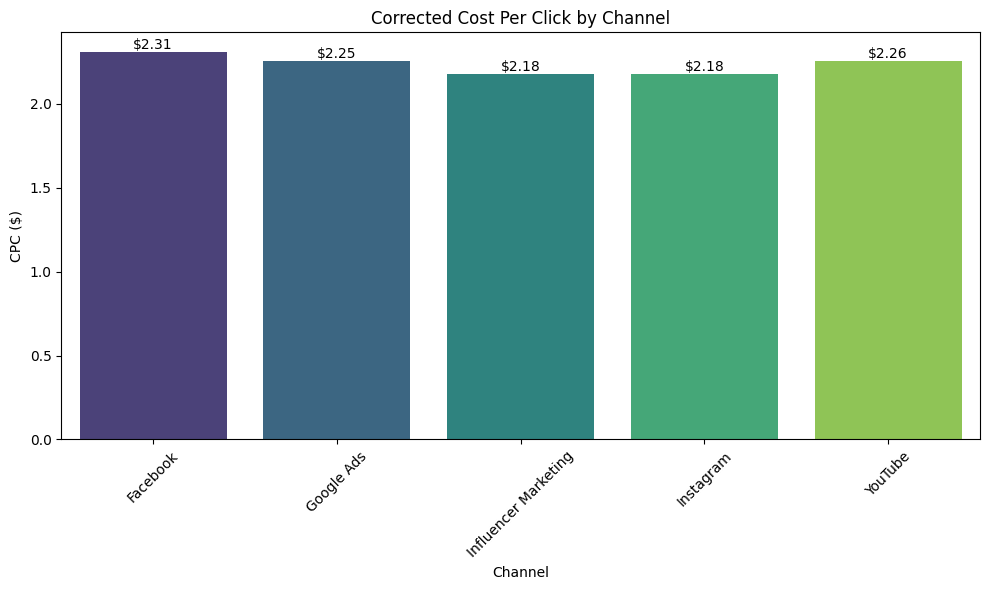

C:\Users\10677003\AppData\Local\Temp\ipykernel_7512\1672252418.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


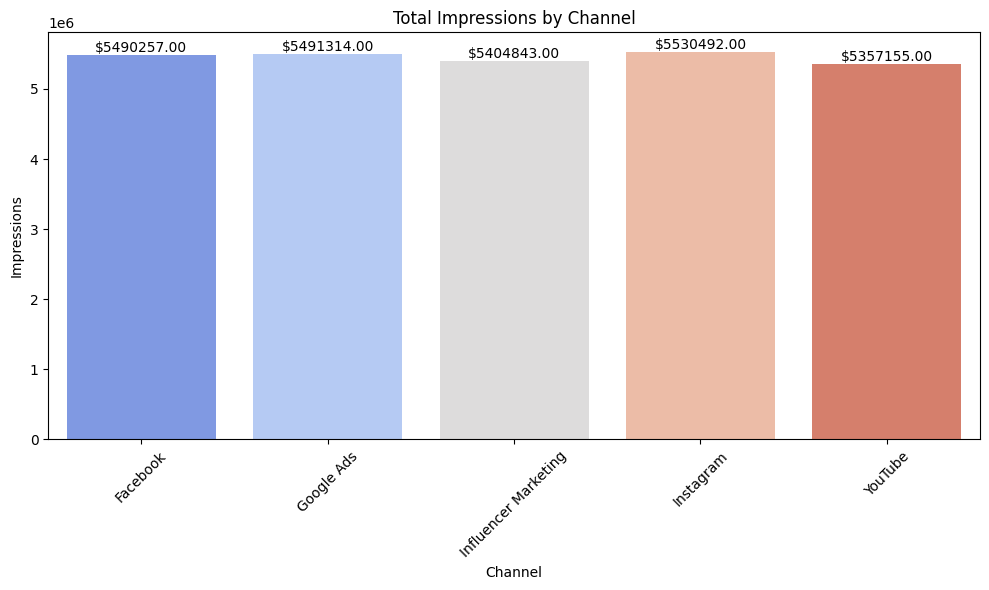

In [31]:
plot_efficiency(online_marketing)